In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [57]:
img = cv2.imread('Resources/sudoku2.png')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

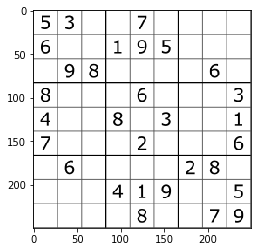

In [58]:
plt.imshow(gray,cmap='gray')

In [59]:
dst = cv2.GaussianBlur(gray,(1,1),cv2.BORDER_DEFAULT)

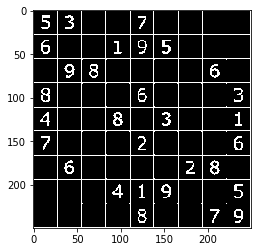

In [60]:
ret,thresh_inv = cv2.threshold(gray, 180, 250,cv2.THRESH_BINARY_INV)
plt.imshow(thresh_inv,cmap='gray')

In [61]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[0]
    rect[2] = pts[2]
    
    diff = np.diff(pts, axis = 1)
    rect[3] = pts[3]
    rect[1] = pts[1]
    
    return rect

In [62]:

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([[0, 0], [0, maxHeight - 1],[maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [63]:
#creating a function to get the different position of cells
def getCellPositions(img_PT):
    #resizing the images to take the shape of the NN model
    img_PT = cv2.resize(img,(252,252))
    #computing position of each cell and storing in an array of arrays
    cell_positions = []
    
    width = img_PT.shape[1]
    height = img_PT.shape[0]
    
    cell_width = width//9
    cell_height = height//9
    
    x1,x2,y1,y2 = 0,0,0,0
    
    for i in range(9):
        y2 = y1 + cell_height
        x1 = 0
        for j in range(9):
            x2 = x1 + cell_width
            current_cell = [x1,x2,y1,y2]
            cell_positions.append(current_cell)
            x1 = x2
        y1 = y2
    return cell_positions

In [71]:
#using the trained model to predict the digits in each cell, if cell is empty fix with 0
def predictDigit(cell,img):
    pos = []
    img = cv2.resize(img,(252,252))
    img = img[cell[2]+2:cell[3]-3,cell[0]+2:cell[1]-3]
    contours,hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0:

        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            # if the contour is sufficiently large, it must be a digit
            if (w < 15 and x > 2) and (h < 25 and y > 2):#multiplied each number by 9 due to the resized image
                #pos = (x,y,x+w,y+h)
                pos.append((x,y,x+w,y+h))
                break
    if pos == []:
        result = 0
    if pos:
        img1 = img[(pos[0][1]):(pos[0][3]),(pos[0][0]):(pos[0][2])]
        #img1 = img[4:25,5:23]
        #22-3-2020
        img1 = cv2.resize(img,(28,28))
        img1 = img1.reshape(1,28,28,1)
        img1 = tf.cast(img1, tf.float32) #for linux (tf2.0)

        result = prediction(img1)
        
    return result
predictDigit(0,img)

TypeError: 'int' object is not subscriptable

In [69]:

def extractSudokuDigits(img_PT):
    #we start looking at the middle of the cell as this is where the sudoku digit should be at
    cell_digits,num = [],0
    cells = getCellPositions(img_PT)
    for cell in range(len(cells)):
        num = predictDigit(cells[cell],img_PT)
        cell_digits.append(num)
    n = 9
    cell_digits = [cell_digits[i:i+n] for i in range(0, len(cell_digits), n)] 
    return cell_digits

#testing the extraction process for one sudoku picture
a = extractSudokuDigits(gray)
a

ValueError: too many values to unpack (expected 2)